In [1]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
import time

In [44]:
import requests
from PIL import Image
import io
import os 
import base64


In [41]:
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
driver.get("https://www.google.com/search?q=dog&source=lnms&tbm=isch&sa=X&ved=2ahUKEwie44_AnqLpAhUhBWMBHUFGD90Q_AUoAXoECBUQAw&biw=1920&bih=947")
driver.maximize_window()
time.sleep(1)

#Click reject button to be able to scrape the images 
submit = driver.find_element("xpath","//button[@class='VfPpkd-LgbsSe VfPpkd-LgbsSe-OWXEXe-k8QpJ VfPpkd-LgbsSe-OWXEXe-dgl2Hf nCP5yc AjY5Oe DuMIQc LQeN7 Nc7WLe']").click()

time.sleep(1)

#Click on an image 
#imgurl = driver.find_element("xpath",'//*[@id="islrg"]/div[1]/div[%s]/a[1]/div[1]/img'%(str(2))).click()

urls = []
urls_schemes = []

for i in range(0,10):
    imgurl = driver.find_element("xpath",'//*[@id="islrg"]/div[1]/div[%s]/a[1]/div[1]/img'%(str(2)))
    src_link = imgurl.get_attribute("src")
    #if(("http" in  src_link) and (not "encrypted" in src_link)):
    urls.append(src_link)
    urls_schemes.append(parsed_url.scheme)
    


In [46]:
#Check how the pic src is saved within the webste 

urls_schemes

['data',
 'data',
 'data',
 'data',
 'data',
 'data',
 'data',
 'data',
 'data',
 'data']

In [59]:
# Save image that is embedded in the website 

image_data = urls[0]
# Extract the base64-encoded image data from the string
image_data = image_data.split(',')[1]

# Decode the base64 data into bytes
image_bytes = base64.b64decode(image_data)

#Create the "images" folder if it does not exist
folder_name = "images"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# Save the image to a file in the "images" folder
image_file_name = "image_file_name.jpg"  # Replace with the name you want to give the saved image
image_file_path = os.path.join(folder_name, image_file_name)

with open(image_file_path, "wb") as f:
    f.write(image_bytes)

print("Image saved successfully!")


Image saved successfully!




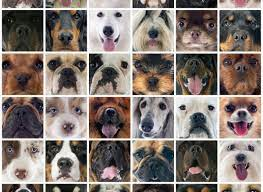

InvalidSchema: No connection adapters were found for 'data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAoGCBUVExcVFRUYGBcZGiMaGhoaGhwcIx0aIxwfHB8dHB8aHysjIyMoHxwfJDUkKCwuMjMyICE3PDcxOysxMi4BCwsLDw4PHRERHTMoIygxMTMxMTExMTMxMTExMTExMTExMTExMTExMTExMTExMTExMTExMTExMTExMTExMTExMf/AABEIAMABBwMBIgACEQEDEQH/xAAcAAACAgMBAQAAAAAAAAAAAAAFBgQHAQIDAAj/xABQEAABAwIEAwQGBQYMBAUFAQABAgMRACEEBRIxBkFREyJhcQcygZGhsRQjwdHwFUJSYpLhJDNjcnOCk6Kys9PxJVSD0hc0U2TCFjVDRKMI/8QAGAEAAwEBAAAAAAAAAAAAAAAAAQIDAAT/xAAlEQACAgICAgMAAgMAAAAAAAAAAQIRAyESMSJBEzJRYZEEcfH/2gAMAwEAAhEDEQA/AJXpGbUcW5+iSB//ADT9v20rvMrQqFpUhWwSru3O2428aYPSJxpjcNjnmmnwhpBTpHZtqiW0qN1IJNyTelZPpLzNRtiAB/RM/wCnS0NyH3JOFdDWt1XK6bQVkbkg33t7KgY/h8oQpZI7NMkHaBMyenP4Uo/+I+a/80P7Jn/TrI9JGaRfFD+yZ/06FB+RkTFudomQIIPeBMafGehtemnL3kqyrEfWBATiGwFKsJCB4czS8fSTmn/ND+xZ/wBOmjKOM8cvKsQ+p4F1GIQhKuzbsgpBIgI0nzImnQjdg7CPPO6Wy4h1sySpKhaB6sAC3nRjF4FWjSgWiY8RS4n0nY9MfWhfX6toW9iB7qJ/+IGNcSktPabd76ts39qKnKD5IeMuKuyRleDcDiSUlOkzJHt+yizzEJkQR4XtzoEjjTMU3XiJTN/q2hb2IrTM/SRiQUht8AJP1ighs77C6b7X07Usovko/wDB3PkuWtehs4YwMLatYKSfcRTXiD3lA7SfnVa8P8bYxzGNNrfBbW4hJTobHrLAIkInrzq2S6ZN+ZG3jVFDiqJcrBDKATe1exAFCcx47QjFjDpSpSdRQtwRCVDlG/hTEcaqAQbETsPuo1QWwJisRymo7K55VE4l49+iupRpUsk3ACRHjJHjTBlud9u0h5tepCxKe6PtE0WjWJnpXUE4TC/0q/8AAY+VJ3D3EK8K+XE95KkhCkE7gAXB5Gb+01ezTy1ISZuSeQ+6K5YrGFCTcE9YG/hblQtIBWXA+Yhb7jjqD9bKkquQIO09YANHc+xjS8OvSkk2HTmL3pcxfHWOOLdabeAbC9KPqmzYAarlF7zTZlee4kp1uud0CboQLdTCaRxSHU2xA4mz90sDCkjQmCDeVpTdM9OVQvRUqc3w/XU7/kO0w5b6QMU5iyC7oaK9KUltu3ISdMxO95k1Z2U4pwhIcKSqDJAABsSCLfCn60I3Z81uLi9/PxrGvvBXvt91WExxrmAbBU+Cs/yTX/ZUHHcd5kg/+YH9k1/p1lNXQeDFHt2iLgjxvY/bWH8cVBKQQUInSI2m/wA5PtPU0yj0iZl/zA/smf8ATrvhOO80WSEvz/0mf9Oi3RlBsr1OpR53Pvq/chyNDuBwKlkyhhKbGKTEcdZiJCnwCP5Jr/so9nnGGMbYwSkugKdw/aOHQ33lTE3TA8hFL9g047HVGHRoLfKl7O8thQCbwLQOV+QFL+D42xqhqL4I6dm3f+5XJXpBxl5c0kSI7Nv7U9K3EaGZwdoOZdlKlG4IEETtA57ijGJwySjswO6On2UqMcbYwmC/BOwDbV/7lC8248zFpcDEHTylpn/srcLNPO5O2iy+EMpQ0tSgLlEezUD869Sx6JeK8Xi8U42+72iUtFYGhtMK1pG6Eg7E16jVaJ8r2IPpgcP5WxI6aI/skUsOMJiUm+ogAiDpEQTFv9qcvS2gHMsV5ov/ANJFKjTRCJ5n5UGKclNnlXF1BiiTqEtqCBBVEmR8q4rAXqgQU/iPOsYgJQPh0505ZMvTkWLP/vG/8KaU3m4APWm7J2dWRYtPXFt/4U0UYW8IgK7s6dQvsdXh4eyjmDwnZJG41G8+HOhnDGEUtaSoHSlWknyi1NmLwq3HQEjuJFztellkqSj/AGUWO4t/0R3UBSQDEGx8JoXjMvDKFa5iYKREK6TInnyN6PnAqWCALjxvXDiXALcbQRci58RH329tCWWKa3o0ccmnoAcIPj8oYQf+4aSB4a5+2vpBTdyfE187cA4VKsXhVK9b6QhQ8e8k19FOLifM/OqsRAvEZIyp3tS0jXzVpEnzNc8Y6NYFhyohmmKDTLjnJCSr3CapLEcd4jtCrWko1dBtMRTJWayzs3yNp4ha20LI5KAPzqSyylACUpCUiwAED3V04exiXmEuJ2UmR7DW+KUJEUrCiYF6GR5mkzjDMXFaWGZLrlpH5iPzlHpawpmzl/Swk9SRHj0oPhMGG0rdWJdXY+A/R/HjUpOgpWLmG4aSlItqXG/2jzN6OsMJWyltcG0KSRYnofuqJj84S0grUQDMC+5i9BsFxUlwBBIKjMk8/KKytqwOk6BPHGSjD6XWkkJKxKeQIvadgQNusVZfBOK7RCQb6QYP6pSYHsmKFYdtvFsqaXBkW6xyI8Z/F6k8F4ZbLiW1cgoT1ASY+EVoyszVFXcS4ZSFDvFCeShEWIEmxtJAk2m00KzpDiYSsyesRPjA2phzltt1CFLupFj4ptA8pE8tzUDF4B15wrKYEACx2jl+OlHSord2LPbXiiWTPuXCBN+k3ojicraAIMhQtcHf21ywiF4Z5K9JgHpvei5JqjJUyM6HC4dSwpXNIH7yffTXxgn+D5dOwwsnlPeECgbCG0uKcBkklQSI9YgpMn1ogm20+VHuNgPo2XpMx9Hne8hQiilTEm9ATLMUWll4JLo9QJgpAUIPdncXFcGG1vqLihp1Kny/G1EMFiVKJBI0gQCANvd0tO8W2ruhaClSUwm24Bufd8aySTsRttUDMfqYhY70K/3rfH52jEoJW3ptATaSf1fKQb7zWuJYdE6rjpZXwoUjFpGoL2jpuBy8Kak3YLpUPXoHTGOd8GFf5iOXKvV19COKDuYPKCEohk2Hi4k1iszLoG+lZn/iT566Pg2gUBdQAIHQfKnj0k4ZKsU8Y7ySk+aShAP2fClLOGOzXHLcQKjN7opFewG+kFUgXIgn28q0Qi5P6VbPuyqE8q3Qqb9N6b0IaPo7p8KashWBkuKnY4psH2oTS8y1KVE7fjlTPlbA/IuJn/mGz7kiPkK0GGSBXDbwS6tH63aDyKQPeDUzijPS33QYAUPMiBynaaFZHPblY27Pc9bD7KI5y3rTBTJFwYqTqOSyyuWOjhieICkpSAEqUZSoGwjrPKmrNniMOlxdiW+95qsfhek7I2lIcStYkD77z4W2ps4iR2uGWCCREi/t23oZuMpRQcScYti7w28lOY4ROmZdbv0Jc/2+FXfjsRpUqep+dUhwm2lWLwhnvB9v4OCrszjDyonnNdLIROGPzFsICXCOzdGi+2raD4KBj3VT+c8OobxHZFQCOSSROmfVmNPvvVp4zLkuNKbXOn1vaL/upQzFGtzUbm9NF6Kwx8hjbzRvD4dplBSHXAENNi8A7qMcgJM8zRIrvE0t5VlzZUnElP1oGiZJ2ECAbAAHluaO4NEmlkxXGm0FMU1rQ0T+aon2xaoGZrAEHxv7JNE8UsJaQOZ1EewUucQud23OQPMgx8qjkNAWOMsrLjQU366TJEjY7728KVOH8lcLyVqENidzcq980yKacdWq9twJ/F71GxeVuITIlOxN/hb3U0Z1ChnjT8hk4ZbLe3WR77inLKm5ck+JHtSfvpH4MdJaIc3BIn4U85LNvCR7NJqcOwS6Kqy1pLr5a5arGOU034nAhKSq4ULoIGx5chS1kzYSUutcrx+7rTMvEuvaRrbSn84QJPnJtR9lEIqMGtSkJ1K1JMOEgHUCCDP2eVMOYZQC0GwLJT0N/cKLHJ2gSRiEE/okfdUXM8wUzA1N9NRBnfkJuYppbNaErH5aWdx7eft6UQ9IawGsvCbpOH/+QolneIDidakwP1j8gL0RxuStYpvBlStOnDSkC1irx6Woc+EXKQjjyaihU4Uy7tErUr1YPwED4n4GuiFhoIbDaiNKlKcAIAUI3MQZ2ibWppewAZQG02RHhe89JpZxriNWkyoz6o6zEx1ikxZHOTfobJjUYr9BofU68UtpVIc0RBnTIBVMbESQfDxoVxNl3ZrX4H99N+VoHaEp6RPOhOcYXtNaR+kOvj186p8lTr0J8dwv2Ef/APP3/n3v6A/5iK9U/wBCWXqaxzhOxYUJ/wCois1Xknslxa0GOKsrwhxrzjmJdQpenU2EApBCEgEHyA99D8w4ewTidZxL4ERIQk8o50K9K+eIax7jcFShoJHIdxJFaZPnHasR+cL36VzTlNO6OrHjhJVZunhrLAB/C8R59mn7q6McLZcVd3F4i4j+LT91RMY4Bau2EdOnUmxFK8khvgiSV8OZcgaDi37kH+LT7tqPZXw7hV4J5pGId0LeQsrKUghSQISAbQQKrDiHN1BdjMGfOKsj0b5il7LnViQUugLnlCQflVIuSVsnOEekey7gzCtFRGJdOrq2n7K7HhDBrJ1POK8IH2GlDiDjhQWpLSCUA6dcxJvt7j7jW3B/Eau2VrUTqtBvWal9mhU0tJjWeC8EDZ1wGNwP31MHDbAQUfSXCFJj1E7GhzmPVrmITAvS9n3E5S8A2Ta0Dcnpapxbk+h34rsY8j4Fwrb7biMS6pSXELCShMSk7G2xotmvH2XturbW44FtrU2oBpR7yVFJAIF7g3pe4B4vRicQhpSVJWSCkmIMHqKrnjlyMdioN/pDtxyPbL+NdEXJ6kQkkui68v4qwTyghDjhKuRbI987VhfD2HUSQ6sAn9EVTnAuODOJAcB7xi/JUwDVzh4hIm1F6DGco9Mk4bLmEJCQtcD9UVJbbZT+er9mhi3IG+9LbXGbCXlMuFSVBWm47s7b8qW9mbb2xt4qca0MrU44gJWrSUI1yYghQ6RQnGv4QI0rdd6To8JHw+VY43WU4RpYMBK1EmJtHmKrTGZ646kpCSPG9/fe3maD5N9aDFRS32Oq8+ytvd56fBo/YK1c4pylQgvvf2Kvuqr31kyFTI/H2VxSKooRoRzZcWT47L7dm68Z5dnG4/3pmybMcP2iGkuK1qUopSpIBICFEjqBEmT0qj8szhbUfopEQOftp19HOapexjRCCD35NjH1S+cTScWn1oe4td7JuHznK0CQ87H9EflXNXFGU7dq8Odml/deq4cSS2kbW9/4+2sowiVAOLGgXIAnYWJ362A86ZxiIpyLBc4kydSf410Rz7FX3VriOJsncABfeMfySvuqu3m21aURGoSm4g7RNhEyKHYrDlBCYsbpPOOhPhW4o3ORZuLzjKViPpWIAHRlX2imfs8N2eDeTiHQjsNCRoB7RsqmVg7GqMProHUEE+P4FWxindGW4EkTGGBilyKo9D4nykrZOx+LwZ7pxbwMRZuf3TQRtrK2wZxeJJNyot3+ApXxuIXqCnCnbVA0mBMRY2PhYxXDMMMtxzQ2CYHeP4tSKLjqlRZqMt2xzwWMyuCtOKeINrtc6805leoj6W+VG92/3Uooy8NtRznvDehX0spkBQF5Ox+Zo8eTdApRSuy8OAkYXt1KYdWs6FSlSNIgqSZnqIj216gfobcJfcCgAoNqBAM3C0V6jHSolk7Fz0m5UteaYgpSDr0dJjsglQHgaFYHLnGuWkDb8dadfSCucW4mLykA8xKU/fQDNlKCeRI2HhSZMj+p0YsaS5GjICiCqSa5ZiggQgwDQfEY6+kG4ufDw8Kiox61HSkk3iOnjQ+KS2H5YvRq7h1arjvidKvOx8/x1qyvRngYy7EhYhLjosLDSWwmB7KUsC2NJURsQfjB+FWLwovVhHhAstIEfzadTclxJzxpeRVmf5A4h7swjVKoSRFwTaelGG8C3hE9opRU5zKbT4IHIT+dTsnA61JB6FXs2+00n8f4dtGlKZ1zKjOwgADpG/xopuWmTa49EJXFwMDs7AxIXffrG9dzlrboDzMdrEifVXv3VDkTe4i9JZZMxJjeaefR0ELC2zuBM9aaUEtxApN9m3osypSsShwoKW21hQ8VyABtypb43WTi8Ugk6RiXu6BvLyjG3UVbuTYUpdbGw1j3zM0jYDKe1zTFrWAW2sQ8sjqe2UEfG/8AVrQk3bYsl0kRMBl6Wh9LxIHaKPdTFkWEADmr9Y7cpNYxfHDkx2adIvfV43JCvOmHjR8fRlyQnYAHmZ9UD2VWK2wTY77gfOjHy2wSVFo8OcQJfRo9VXQmdJ5GeaT5WoDiOGS5ie01gd8do2sXnVqIBAuD16GonB+VrLiXUhQAO8xIm5HIxF6stGBSpYX4X8SLj7R7qR6eh49bMZ7g23MAhp0wVFQQo/mqixvVUY5pba5WTCZEJEJ3va9pvVl8falM4XSSD2qxA592INDsRkilgFVxEb/L8RSTyrH37KY8fNCVh8Ih5VoBI2ChuN48OcVvjsqDaZtJUfny/HOpuIZZYUQlPPYQII8TXDDPtugNrcUFeYifC/TmaKyN7XQHiS03sCYhsq5BPh0HS0AfGnz0WYMJxLa1nvqKwkAGNPZrJkjukyefQVAZ4Y0J1AkzsBc+0iiHB5UnMsMg7S5um/8AEu8ymR76aOaMnxQJYZRXJi47gFOKJgJSDCZ+Eey9Q81tCCnugQARyH+1MOMfS0GtilJiSDtI71vBRodj8vViCpxlHdAGq47pImDf22FJGTk/4BKKWvYu4oyRsY2Mc+fs291b4lrtEgbRz+H2CpeDyRWhwkkrSqI8gK0U6lsLCvWUmII2B2JA62qkrb0JXFbA7yFJASr1kq1Dy+6rbKAcNgdQBR9Ggz4mq0feLjTcpuLf1bifaSasRT4Tg8vSrf6Mn3zFLNtxZTEkpoDZrlbSYNiORP4+yh72IUhlSW0y5qsTERzUqT99MOPalCiOfl89hStjUGKljm3LZ05IJR0c8XilBaYEoIVt+lqgb8orirChStQsQfhyrRhBmxuPhRPCs98ePxHjVZzp6Iwja2NfobP8NcjYsmfE60ffXqz6H7Y51Nv4lR2i3aI8IrNPHolk+x042YK8wWBG4PlCE3pbzxULMmnPizLXV4t1aW3FJhMFKFEHup2IF70vZ7k7yjIw76ugS0v4mK5JpuZ2QlFQRX+YlRUSCY6fbU7JE6Aom5V7aYHeE31i+HeR5NrJ+Vaq4cxKBbCvmOYbWD8ulXc7jRFJKVg1l8gGOZiKs3gNE4NyDMrT/hpDRkWKVA+iviDN2lj7KsjgTCLbwziVtuJPaAgLQQdhcAjaanjT5DZJJxJbLcE2vpPzvVY8eNk4kpQCVKAgdSeg93uqzsa24h3UlDigpvTZJMK1Ty/G1LTeRPuYkvuNuWMIBQbJjy3q60QtMqk4NZUO6dW3OZ6U2ejdJS45qTCwkQYvEkGPO3up8/JCyvV2Jkc9Bn3xUBjIXk4ntQhyFAhUJPmN6zk2ZJIZ8An6xskbkfj30qYHCdmvGuEx2mKcGwAhLizPvUfdTnhsOsKbJSrcTY2vNLHEODxELaaacJW66qQlUDW6sgyBEaYPurVpi3sQM0wrmJfW4EHs5CRf1YgT0HM+01OyvhZvSntASvvSBttAv1G803YHJ3W0BPYr22CTvF5tFc8LleISrvNLjl3VTHTahbGSjYscCLcDjjRKtKJtGxmJnlztzqwsGNvL99L2DyV9pxTiGFHtDKu6QRcnmNqYMsQ8o99lxAHMj5da3bA6SNeIEp7FnUrTDiojmYrVKUlsgG8dT8qi+kJx9DGH7LDuuy4rWltClKSNMhXdBIvQHC4rGIIIwTykdexcCgT+qUya5s+GUpWjow5IxhTFjjBlSXJBIVPKLj7r0MyJiXwpewIIB67VZWK4YViwVqS42ojm2QfKCKi4bhBxshQ1qIMj6si832FVjJrHxEkk58glhWklAkwefiPGZ+yu2Q4RIxja5EgK0xz+rWJt4GoGJx2JgIGCfJFtaW1gf4fl7qi8LLxv5SZSth4N9/W4tpaUj6penvFIF1QJ6wOdSxYpKSZTJljwaFlh8OoUgiVBOrz02PtKY/Zpg4fwrTTbpad7RLgQdM+rEwFJiQoXG/KhOQ5DikvoKsM8EzclpcQQQZkbXqUnLMVhnlacK84253VaW1mL+sITy+/rXS2oy4/pzwdpN+iWlsd6Bz+z91J3FbLSVuK1qLqgkJRFht3p6QCAN6e8PgH0JJU06RvZtwk72A0zPnFJ68gxjr6nHMK/c/8AprgeHq9LUeXHZXMlKkgDil6QhHPSJ+dNPFOKKMPlXjhZPSyhvFC804bxinjGExERv2Th/wDjRrj7IsUrD5clrDvLLeHKFhLSyUmRZQAsbc6aEVx2c/J87CTmIStsH9K9jYDwoMxhw64R+aN/H91aZFlWMKOydwmIAHqqLTnPfcRRRvA4sK0JwrwEXV2axtteIrlcHFujt+SMkrIhwTQ1BIMhM+wn8fGuOCWlQT4b+XWprmWYrVp+jP3F1dkv7BQPOskxiUkIwuJWVc0suWH7NMoyl2K5RW0NPoaI/KD46MqjxHaIv+L/AAr1Y9B+UYlrFureYdbSWSkFxtaQVa0GAVDeB8K9XTHo5Zdhn0g8UnCvrQlw6yBpTqMJGkXgHnSjk3F2LDii6+uDeCtW/QCbCpfpRy4uY5wJT31LQQq9x2aQBvAEyTIPwNL2JhuG21ElI0qd5mPzU9PsHWhKKWvbGhffpB7H8Uv6khLzok/+osTPS9FsfxG80yTrc1RvqUoDzM2qv3cQoG6h3fCYPmTvWgzJ1JkLJ8CZBHl1pPhfY/yReqJuH4xxiHO0OKdKTyLiyn4mrK4e4kcfwC3QpWtLqUnvk8pMGZjwqqMywocQHGxAHrp6AncRy5U3cJOhvKcUoJ0ziESJkXA2vsEwLk3BqrSatEnadBfMuInVizrifJahUzI83dEBTrigf0lqPzNIy3AEhY1rKlBPcCSAomALmT7PHpR/LHSUg7EWvaOdTaktlFxehpzzNHEISUuLEz+cfvoMnM8QkKUX3CTsNaoHS01KzhBUymOW3upTx2JdbdbZSlThWTeOe/lA8azUpOkZcUrY9cMYnEKcTrccUkqG6lG0+6l/i7iZ1t15tLq0wtQGlZEALPj4RTNwhjUuIbI5kfOqw9ICScU+E79qv/MVSyV0mNjdW6OuE4lf1d7GPQTIl1z3etWuMzrGOLlvE4gJ8HXAD/eqBkWTp0B1waj6wBNgkfnH3W9lFVZq0lCNTjTalXCezUs6OqiFAJmDAkms4ty8dlFKKXlo6YHiDEhCg5iXwUiZLi/vrV7PMSFyMU9BG3auEA/tVGfxLbspOkpOykSAb3sbggxY0HxmFW2vSg6kiCJ/R8DUmmrvTKKSdNK0W3w5jnnMubWpxesuLBVrVMA2EzNLmcZw+XFAYtxttshTq+0XtyQkA7m5ovkb/Z5QhRt31k+/8CkfJ8KcYXka9Ku0DlxPdgp28Ptroh9Ucc15P/Y4/wD1Ip/Ddo046mCQDrVJIteDzqVluLcCCtx92J1GXV2H7VD8NlrWHYQ2Dfr+kZJJ+NSMywHaYdQ21Dl4i0/jlTMREDEZ04tztGMS6UggKR2qyAOukq686beF8c4t5GpayFTZSiR6pPM9arLhTh3ENPypMJEhapspOmNufW9WBwW4PpKEAyUFQV+wr7aLRvQ7Fwi8moz2LIHrX86T/SSzjl6U4ZR0XlKNKVauRKlm43sI+7tlDzgYbQ4SXUpAXJCiDvcpsbEUG6Ak2MGHzEk3J99d14+AO9v40GbbIKR7/bXsy7qfZv0pLYaDaH1ESFH3mo2bYlSCghSpKNpMTO5qt+Dl5i3i9LilKak6i5pIImE6CLgxfci1WFn4MtwJhHsma2e+GhsC81YLz3OFsNhS1kEnko/KaW8y4mWRqS64PALUPtpJ44feL5KnCU82yYIMkGBFxFx50R4Sytx9pTizpbGy3DAA8+d7Uvw+KbZdZFyegw1xQ9qEvOR/PV99HMHxOpaghDiyrmCVH7aFM8NNKQsNYht1wIkNpPeJA5TvSChbvbAJWpCtionTBmBIP5o9+9FYbZnkVdF98OYpSnjqUojszIKiROpPLaa9ULgNwqUlS/WLUmRG+m8cp6V6hC6JZa5aAvpGSlLzjsSpKQkeagB9/vquH0d3vKlVyY5He3yp39JuLnEuoBjSUD26AonyhSfdSNjV90Debz1POqQjuxZPSQKUj1xJOqTJPKwt8a3wzaYjkKwomRFwNzIsI8fOu2DTeRcH41YSghkagVFpWygRfxsR9vsqxuEMtR+T3EFMpLiVQeZjn5VVgXpXqB2MjkRVp+jPEl3B4gkXDoHn3AZHSZqU1Wx1K1RCx2SKcWkIhCRYweXQAfbRnDZOltICgD+OdFcrwZ1a1ewVF4nxIbSVX8aVW1sL7pGCwkjTFvChOZZNqiCQDbUDcT16+2l9XELrb3ZSiAYKtUpExufCadeHcUH21GOoF945jwpjdEXhvJEtKa0fmrBJ5kzuaQOKkBWLfk7vuA3/AJRVW5laSFJJ/SA+NUjxktX0rF8v4Q7ED+VVHtqUldFMcuLZjN8whns0wNVvJIMAeFBccguEK5gAbcth7q54R9x1YbiSowOUefUc6nvZS4dMEpgj37z8KvBcURm3N2jLB7MN6YHekkTz8+XKmBooVBPIx7+VAcwwzjYTrBJgkJA3jf2VjI8Utd1CwNonflUc0bVlcE3GVFrNYftMrbSnbtFfOl7hDLtONcWVBKENK1eIJSPgb+6m3g068ubkD+MXt4Gl3ifCFjDv4iT3lhoAAnnq5eY91Pij4pE8r8m/5ImYY9Lj8ggpBgCOXUE7U04VhfZJSrmTfw5VUxxakqAUYvzHP2VcXD4UrCMqWL6Z9knSf2Yq0o6JRYL4nxX0fDOuAwoJASP1j86F+ipCk4llSiSVhUzz+rWfmPjXD0h4pLrjTKFSlYCrchO/uE+6jXAaR9JZi3r+7Qqk9DDS8/rTtJSYNDcasYZlbgRqUTqIvz5mOgoq0zCiOqp+FBOKniWXINovfcdPHyqdb2a9aKqz3Pn3Xl6nVhI2gkAGYgCYiLzTPwHn6ln6M6tS5gAqnUkwdQBO4sLeNImPKe0tc7dfgKNcDuI+kIUVEEeqeXkelXdUSVlu5MgI7p3Tt5cql5yuQ2md0z8aj4XvBKuog+6Qa9xKvStpI30Wv41z5V4HRhfmBM64fS6tOoCCRqMXjntUXjxLSsEcO39XpskJsLcjzqF6Qc3xbLiHGCdOiCmNSSqZEg7ztS9nHED7zLa0qQNYvCEylUwRcW2o4o0kyslKbpejnwvhCMU0vUU6fHerA/IbTr/a6EidwU/ndfCarXhfGON61rXq0hSoVBuATb2jlT5wTmz2IJedMISgBCEjSCoiVKIkzewvyp8q0LGEoNP9HXIkAOEQJCSJ8JFq9UThrEan1pvGgm4/WTXqjj+oMv2K49Jf/wBxfJNhogR/JppQxzkxHrGwH31ZPHmMwQxjgewrrjg0ypLmkHuJIt5GPZS63mmV6p+hvyAbl72VbmkIkxOXhgkkSSeZHWsMyg933fdVn8O5VleMBUMO6gjcF1R69KIPcJ5aJllzu/yqqPyI1FZJKFCStMc9pn51YPolUoYPEKjd9MD9XQB++t2eGctKtScM6YGqe1UUmKLHHYbL8G46jDuBCnUhTeuSVKGkQTYCwtQck1QOtjBlqwQfhQnifC60kRSuv0oYZBg4R0H+kRFHHONmShuWFkuKCUp1pJvsdqRySpP2Mre16EtvhlRUUaRo3Kbdf3VZWRYUNNerpEV7iLNGcGx2xZKrgaQQDfzoRmXG7SGwtWHcIIkQ4mi5RVJs1uS0g1gnO0cTFkpVt1vVV8VZeTicSrl2zhj/AKivnJpq4f8ASNh3X22UYRxCnHEo1FaTGpQEmNxJrji87wa8TiUHCulTbqkrV2gAUsLUDA8SCfdU8iaVofHJXsrbB6cLjELWk9mZSTEkEpI1ewmT7aYsXiEABQMgmUmbEGpXEuY5WiEu4R9aj3tKXjYdT08qi4PNcr0pSjA4iNUx2+x/HKqY5PjszaTaQPz3MQsIw6DCyZWoboRawVyJt7POsIwWi6ZjmKn4vNcqaWFfQsQVK3PbHfnvRIZ/l2nUnCPEAcnh7vOpZFKXQ0JxT2N/CK4y9vl31/OhOY4tTihh41IdAKhzTACtaTyIj2xFF+FMaw/gWlNYdxLaluJ0ly6YMKJUBeeQrdWX4QuBQQ4FpskpcI2qkZxgkpEZJzk3ErXD4NovQpwrAVKkrRBV3pgqkjfeKsM5uC1o0wjTEiAI20pG8RzgVLzNeDR31YUFXNQ0g+ZMUNwScJiFayy7KjF3DcciLAR5Uz/yIP2ZYp/gnYjEFzEkwASAARySLx8hTZwMP4W0OgWP7hNbZnhsDh1yWHCo2/jD/tUjhXMcKrFNhphxKzq7ynJAhtRMjyEVvki+gOLQ1aZUCek/MUk8d4dx1AbaPfWqOkgAk+FgNq4ZhxzhjpWpp9ISLaXoG87DeheF48wQWXPoj6l8it1Jt+qNhWFByeGXEAAj2yDPt9tZx/C6kILjZlaNwnnAmPHnRpHpEwbgAOCcgWu4msK9JGDEgYNy+8OJ+6jyYOKGXg3H9rhUEzqQRqnobX99d+K0lS2ZUR9Xew69TSZlHHmDYBDWEfgjYupI9kin/Cus4rDsPltwJW0FJGu4B2SY3NLPyjSHxvjK2Cl4dDjZadTrQfZ7qWs0yYhPZhBhKpQqPWBuQr9YHmd/nYqGmUD+LI81VzOKYBMA26KpYqS0dGPPxnySKyyfI19pJQY6RvPXwvzp0SwhpsNtCAB5+00YS6yqTpX496tC2wSe4v8Aa3rSTkNk/wAhZJXVJAngZxRxjgVP8WTuYPeT1r1GOGg0XllDakLCSJUqZTqHL3V6tFUjnnLk7K89Jqf4e4B+dpBPT6sGPdSljctUgKUAReCDzANljvEwbgHwNOvpOb/hTh8Un+4mlnB4Rx06W0lQ52+cCta2Ml0MXopZIK1Hp91Fs3zVXehEoUm08yFaSCPlUjgvLFMoOoQSIjnRDO8p7VtQESBI8949tCtAtWKuRZmUrDaxoGpSUkEALANlAEeqbRBi4A5xP9Kaj+S3QOTze2+9EuG8pQ0TDQFwqYBnw62NaelLBAZcuCU63m1KV5H7hFMq7Qsvwp1rChUgpTaxKrmQPVAkXPWnD0fZM47i0lStTTEK3kTFkgjx+RoHwxlbmOdQ2N9XeUP0Buo/Z4xVw4vMMFl6UtCEfqpF/wCcrqT1NzRFMcd5d22DdSPWSNafNN+XlVFDEOKkFyQmNIPib+0X3NX1l3FWEcVoQ5cm2oQDSL6XuHG24xbDYSJh1IEAk7LAFt9/ZWowm8HBZx+EJFu3bvt+ePjRjGYsMv41Sge/jninxAWoH2Tb30A4KxSzmOEE90vtyP64pk45Ufpy0oRIS4swBbUpaj7ySpVLk9IbH7YsrC1qSpYlSyVdI8zztAvauqXFpaIQADrEqgaQiYMze5tI610WgBCoJJBKZG0neD0+6tmnAG5V6sdPWtA+PPw8KpHYrIGYCVQZ0QfMKnx8KhYB5SFKG8j4/g1IecCk6hz+y1aMJIUepTPu/dWl0aPZcHonUBk6CbAOuf4jQvNOLG2lENp1L6qmPZG3trpk2EWrJkBpZT9c4SAdwSSUyPGk93KFdqC2iUrIACd/E3JJ/SJ2tSfHGTthc5R0hlzXOFKYB1JVPrAdDyqTwlmIesISEnvQbgC1vdSfiW9KezUoyPzUwEpH6ytyT4D310yXENso0lUlR7ykzbpFSlhTjorHM06YQ45z8JxGlsJIiFApB+O80R9GuYIdxrWyVwvu3v8AVLvcUo5/lyv41Kg4lQ9YRPtjpRH0SNH8psG9u0J6R2Lo585I+NdEcceCa9HNLJJTp+wHjVal3PdAH7yOU1vhsHq0lXqgEz1A/EVuW+5p/EzRVZCQEjZIgey1I3TKJWgC4saQoNgJKgIIiAZvO94mfGuONwgQVaTKbGfAiRt51KfAMgEWknxk/gVvhhqBSedvurN0BKwUlUGvoTgopGV4NZ5MpCfMivntSItV/cHictwI/kUwPGKLAtsA8YPYlYWhoLJKCEhNpUSBOrcQAf2p5RUfhnKsQ22NYJMyQZBHtVvT8tAQOqufQUiekHiN3DgJR+dzHy91Fb0P1sLqCwAUpUesXtsbUqcPYrGIxAZeDmkrVBUnlEyDAi4P4iOXCXFDzjuhRKk2uQLeUfI1YbK9YvRfjoCdk/h8DWTz0394r1b5GmHT/NPzFepQMRuNsMp3MHG0jcoB9qE0w8P5GnCswTqWo3P3UTxGAAxSndIkkSo9AALVpxE4pLatAuEyPdS17Hu6RyK/GpeXLk1VePxzzatCHwvmSk6gCTcTN4p34LxKyhOpYX3QdQ5zf4CKCexpQpWNLeGCSSLA8qXfSMx2mCLZMAuJAPsVTBjV93x3oBxRiSMLqj/8yBe+8ijN1F0JFXJWDvRNk6WEOi6lFQlREW5AUn8f/SG8c6vSmNe6gD3DZMA+A5dOVWNwK2pKHdR3XI8o++aXvSe0lSta1I7oGlP5151Hy2+NDG24psM0uTSK3wuIe+kBSBJMAAD1uoI6ETVp4xROCWhzvENHVN+RMeyk/hDCBx5JCwIMwoesOYT42qwMx0qSpPIpIPup2LVFRcI5afp+GWPVD7Z/vijXG6lN498pMalEnp6y7+y9b8JSnFtJIsHUAftC9a8dZepTz7iDdDjgInkpaj86lGdu5eijjV8QK2QtCkhOmNhUJ7LXnUpS22pcmJAMeN9o5Uc4fwqnXENhKVTBJKo7tjFjfn42q00oTZKQAAISBaw6V0Ahj5FCjLnGtaHEkRBnl03rCxpWJ3sR7as7PcAdSwpsuAiyRvPKDy6TeJ2qttCnFArNkgAQALcgI8+d6F62CceMqRbPBLR/JSEo37ZcftUL4pxDeHbUptQLjp0DTeB+foHiqxP6tTMnwjqMqZS2ooHaLLigJISTuPfSrnT0uBCUkBA0pBvA3kz1mSrrNTUOTu9AcqVewE46EhWuSkd4XPeM7moDq9gEwTe3LwqfmQuR1sfKoLQMG53g/O/troS0c8nsk5diFIsbA8uR8acPRnhgnMGiOZcnw+qWQPjSbiU2TG34tTZ6LsSDmLIPrELE9YaXv42mazWgxf6AWOXnUnN0aDIvItFzcWAArliAEq08jBHvuKKcLY4IUt11Ij+KEHYWMidzbe1pFc227OmKXTFDC4B8OFZaWAPWlJFj50Sy/DEqtt1pyzDiHCgKGpS+gSg39pgUq5o8EJ7dsCFq0lI2Tbn4k/bW2wyjGHTsE4tmSR4zV9+j9H/DsGeYYTFUR2uo94GDCj8evWr64IX/AMOwh2llNqZEjtmTgE+FVfxNmiX0r+rB0r7MpkSCBMqtbmLTsasjHJJPnSFxzlqW1ocSmCuyyOZTtPsNCL8i0Ip6F3LMcGklwISlKAVkztaAD1lWlI/nVYfDePU402XLKIB2jl0O3lVf5e0kLbBSFgLB0m4PekW91WA4jSuwimyOmFwoaMgclSp3A+0V6scOXUVdU/aKxWXRF9hTEpknb3ioz7OoQYnrI++qd9JZH5UfHMlH+Uik3N3e0VoSkkBQSI5q5gdT+OdC90Hjqy7sbwShaypCgkEyoAiDO/lPhRnKMnSwkIEQnYSPtNVnwtoytB+kuAuuR9UjvFA3Go2E3/3qBxhgk47VicMrWEplxpQ0qAFtSRfUmd42oqJnJ9WXQ42VGTH7Q++hHGGWuO4UoajX2iFeskWG9yYqk8uflBQd0pkTzTf7fsovgkA5JihH/wC03/hTS3dpma400WlkmCfasdMEAHvp3H9bxNcTwshRUt0h1ap9dQISDtpBPLrvVL8M5Uh99La1aU843N4gV0494YTg1pUk6m17SLg9K0Ul4mc23ZbjfCaEq1aUlf6WpKb+ASQBXZ7BYgIIDSVqiAe0QB0kyrlvXzwCnoKf8h4VaOBL7q9C1DUOiU8pHOd/aKLpA5NjPlfCuKRiGF9mAlt4KUQ4j1NYOwVJ523ormvDjysQp1CBClqC+8kSkkwfW3FjFVzwXhwcbhzazrZn+uKN8dZqGHnkJICi44r2qWTsOfj5VOcEkkh4zbdk7C8MZjh3CphpJMwD2jcaZJiCuedTEYDNw52hZSvokuNpSPKFz8TNL3o3xDqnFuKVIMCVE/CndQcLioA0TY6gOV7EzvVLpUKpu9AXLcnzVDynVtlSl+sO0bi9o9c6Ui1hewqLi+DsWVlScMlAKivQHG4BPK6uX2mmZeKU0jvJK7SVdfAdbVX7vEiVPlIOpB2CrHyFCTbWkZPeyxcBl2KawSUBI7QKUSCpEQdr6oPlQzOOD1rUlaBCtIkBxIAPQyfcRNviL4mWk5bhik90uLN+mnn5VXeY41sylMqI+fzrQdbQZK+xtzHgjHFXcZQb7l1qI/bmub3BOOg6MEhKlRqP0hszAiEgqETE8zSQzlLhMlF946ffvtXZ/DLQAZTB98jlf5VXmT4DingPHgg9iny7Vr3Hv0Y4D4OxjOPaedaCW0a5PaNqiW1pEBKid1CqncWoGTv1p19EjxOYsDke0/yXKzkwKCCTvBmPIEMoJSqQC63Bvt6/4mpGY8G41Svq2EobBlKO1bJHM313MzSJh09i0mRJ3vtUvLGF4gLUFxHIfbU5OMVbGjcnSGJfAmOk/Ui/8q1/310wPBGNQvvsIW2bKQXWoIsRssEXAMgzIpKxRKFEKvHWiTGUpcZ7RyBqEpAA26mg5RirsZRlJ1Qdx/BGYOLWsMJGo2Has2SLAev0q2uFcEtrBYdtwAOIbCVCUmCBe4MH2V82PspSSkm/gPnVzYDGIZyrBOLUEpGHTc1pS4xtbBFcpUOr2EUTYD3j76HZ9kBxDRbIjmDIkH31VmM4o1ugBKoBFyFJ3PwqxGMUS2AJOxmljJvbVD3xfiwfkvAi23A4tQXpukCBfqb8ulHXcoWSDpE/zk/fXPM8QUMTtA3PlVZM8TFCl6krcAXp1BKiJPqiRYE3gc60pN9KxnJydtly5LhFIJkDbqD06V6lP0Y5m2+8tSDcNmR/WTuKxTReicuz/9k='

In [37]:
# To be used in case no scheme was found 

from urllib.parse import urlparse

# Replace "image_url" with the actual image URL that you want to save
image_url = urls[0]

# Parse the URL to check if it has a scheme
parsed_url = urlparse(image_url)

# Add the "http://" scheme if it is missing
if not parsed_url.scheme:
    image_url = "http://" + image_url

print(image_url)    
    
# Make a request to download the image
response = requests.get(image_url)

# Check if the request was successful
if response.status_code == 200:
    # Replace "image_file_name.jpg" with the name that you want to give the saved image
    with open("image_file_name.jpg", "wb") as f:
        f.write(response.content)
    print("Image saved successfully!")
else:
    print("Error: Could not download the image.")
    
#-------------------------------------------------------------------------------------------#
#Check which savinf option is the best 

for indx,image_url in enumerate(urls):
    image = requests.get(image_url,timeout=5)
    if image.status_code == 200:
        #Create a binary stream from the binary content by Pillow to open the image
        with Image.open(io.BytesIO(image.content)) as image_from_web:
            image_from_web.save(image_path)

In [ ]:
#HLE
class GoogleImageScraper():
    def __init__(self, webdriver_path, image_path, search_key="cat", number_of_images=1, headless=True, min_resolution=(0, 0), max_resolution=(1920, 1080), max_missed=10):
        #check parameter types
        image_path = os.path.join(image_path, search_key)
        if (type(number_of_images)!=int):
            print("[Error] Number of images must be integer value.")
            return
        if not os.path.exists(image_path):
            print("[INFO] Image path not found. Creating a new folder.")
            os.makedirs(image_path)
            
        #check if chromedriver is installed
        if (not os.path.isfile(webdriver_path)):
            is_patched = patch.download_lastest_chromedriver()
            if (not is_patched):
                exit("[ERR] Please update the chromedriver.exe in the webdriver folder according to your chrome version:https://chromedriver.chromium.org/downloads")

        for i in range(1):
            try:
                #try going to www.google.com
                options = Options()
                if(headless):
                    options.add_argument('--headless')
                driver = webdriver.Chrome(webdriver_path, chrome_options=options)
                driver.set_window_size(1400,1050)
                driver.get("https://www.google.com")
            except Exception as e:
                #update chromedriver
                pattern = '(\d+\.\d+\.\d+\.\d+)'
                version = list(set(re.findall(pattern, str(e))))[0]
                is_patched = patch.download_lastest_chromedriver(version)
                if (not is_patched):
                    exit("[ERR] Please update the chromedriver.exe in the webdriver folder according to your chrome version:https://chromedriver.chromium.org/downloads")

        self.driver = driver
        self.search_key = search_key
        self.number_of_images = number_of_images
        self.webdriver_path = webdriver_path
        self.image_path = image_path
        self.url = "https://www.google.com/search?q=%s&source=lnms&tbm=isch&sa=X&ved=2ahUKEwie44_AnqLpAhUhBWMBHUFGD90Q_AUoAXoECBUQAw&biw=1920&bih=947"%(search_key)
        self.headless=headless
        self.min_resolution = min_resolution
        self.max_resolution = max_resolution
        self.max_missed = max_missed

    def find_image_urls(self):
        """
            This function search and return a list of image urls based on the search key.
            Example:
                google_image_scraper = GoogleImageScraper("webdriver_path","image_path","search_key",number_of_photos)
                image_urls = google_image_scraper.find_image_urls()

        """
        print("[INFO] Gathering image links")
        image_urls=[]
        count = 0
        missed_count = 0
        self.driver.get(self.url)

        ## Add a step to pass the rejection page on google chrome 
        submit = self.driver.find_element("xpath","//button[@class='VfPpkd-LgbsSe VfPpkd-LgbsSe-OWXEXe-k8QpJ VfPpkd-LgbsSe-OWXEXe-dgl2Hf nCP5yc AjY5Oe DuMIQc LQeN7 Nc7WLe']").click()

        time.sleep(3)
        indx = 1
        while self.number_of_images > count:
            try:
                #find and click image
                imgurl = self.driver.find_element(By.XPATH,'//*[@id="islrg"]/div[1]/div[%s]/a[1]/div[1]/img'%(str(indx)))
                imgurl.click()
                missed_count = 0
            except Exception:
                missed_count = missed_count + 1
                if (missed_count>self.max_missed):
                    print("[INFO] Maximum missed photos reached, exiting...")
                    break

            try:
                #select image from the popup
                time.sleep(1)
                #class_names = ["n3VNCb"]
                class_names = ["n3VNCb pT0Scc KAlRDb"]
                images = [self.driver.find_elements(By.CLASS_NAME, class_name) for class_name in class_names if len(self.driver.find_elements(By.CLASS_NAME, class_name)) != 0 ][0]
                for image in images:
                    #only download images that starts with http
                    src_link = image.get_attribute("src")
                    if(("http" in  src_link) and (not "encrypted" in src_link)):
                        print(
                            f"[INFO] {self.search_key} \t #{count} \t {src_link}")
                        image_urls.append(src_link)
                        count +=1
                        break
            except Exception:
                print("[INFO] Unable to get link")

            try:
                #scroll page to load next image
                if(count%3==0):
                    self.driver.execute_script("window.scrollTo(0, "+str(indx*60)+");")
                element = self.driver.find_element(By.CLASS_NAME,"mye4qd")
                element.click()
                print("[INFO] Loading next page")
                time.sleep(3)
            except Exception:
                time.sleep(1)
            indx += 1


        self.driver.quit()
        print("[INFO] Google search ended")
        return image_urls

    def save_images(self,image_urls, keep_filenames):
        print(keep_filenames)
        #save images into file directory
        """
            This function takes in an array of image urls and save it into the given image path/directory.
            Example:
                google_image_scraper = GoogleImageScraper("webdriver_path","image_path","search_key",number_of_photos)
                image_urls=["https://example_1.jpg","https://example_2.jpg"]
                google_image_scraper.save_images(image_urls)

        """
        print("[INFO] Saving image, please wait...")
        for indx,image_url in enumerate(image_urls):
            try:
                print("[INFO] Image url:%s"%(image_url))
                search_string = ''.join(e for e in self.search_key if e.isalnum())
                image = requests.get(image_url,timeout=5)
                if image.status_code == 200:
                    with Image.open(io.BytesIO(image.content)) as image_from_web:
                        try:
                            if (keep_filenames):
                                #extact filename without extension from URL
                                o = urlparse(image_url)
                                image_url = o.scheme + "://" + o.netloc + o.path
                                name = os.path.splitext(os.path.basename(image_url))[0]
                                #join filename and extension
                                filename = "%s.%s"%(name,image_from_web.format.lower())
                            else:
                                filename = "%s%s.%s"%(search_string,str(indx),image_from_web.format.lower())

                            image_path = os.path.join(self.image_path, filename)
                            print(
                                f"[INFO] {self.search_key} \t {indx} \t Image saved at: {image_path}")
                            image_from_web.save(image_path)
                        except OSError:
                            rgb_im = image_from_web.convert('RGB')
                            rgb_im.save(image_path)
                        image_resolution = image_from_web.size
                        if image_resolution != None:
                            if image_resolution[0]<self.min_resolution[0] or image_resolution[1]<self.min_resolution[1] or image_resolution[0]>self.max_resolution[0] or image_resolution[1]>self.max_resolution[1]:
                                image_from_web.close()
                                os.remove(image_path)

                        image_from_web.close()
            except Exception as e:
                print("[ERROR] Download failed: ",e)
                pass
        print("--------------------------------------------------")
        print("[INFO] Downloads completed. Please note that some photos were not downloaded as they were not in the correct format (e.g. jpg, jpeg, png)")


